In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
from collections import OrderedDict
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = [15, 12]

## Load Sales Data and Import into a Pandas Dataframe

In [16]:
df = pd.read_csv("./data/items_purchased.csv")
df['naive_date_time'] = pd.to_datetime(df['date_time'].astype(str).str[:-3])
df.iloc[:10]

,kiosk_id,product_id,card_hash,date_time,fc_number,naive_date_time
0,108,2457,FEaD8IUmESlpzvPRYyZhMyUv/CRtDNIUyprR5w7e/mPkFz...,2017-12-06 22:06:36-08,20.0,2017-12-06 22:06:36
1,220,2884,N8JjRgpqKnQ8BDp+XtxBkfM0If/9GBL+rsOalHjHLdIM8B...,2018-08-08 14:18:09-07,NaN,2018-08-08 14:18:09
2,182,2937,svL2pR3SC6O+B/Kg+78gJsiKDxvCtSUohDLGjj02tGC0MS...,2017-10-20 18:22:10-07,NaN,2017-10-20 18:22:10
3,339,3814,kzaHILrWFehUeo6gjZV1EwvZHNTXGNqTY/Hzv+mL9Bg+vR...,2018-06-13 01:30:06-07,48.0,2018-06-13 01:30:06
4,230,4149,4ox+j2exAB/xLlyHteKO/cNoSdLFb3T29mkacbTAf7ECiX...,2017-10-19 16:27:17-07,NaN,2017-10-19 16:27:17
5,391,4201,3ExgFAomm7KRC3Ju5zdxHR5sGhaNuvdgXGCis0iD3GbtZG...,2018-08-15 18:22:15-07,48.0,2018-08-15 18:22:15
6,232,4111,hOB3nBlofMM/2khWcX9O2CoUZ4YyCFSXB6vbCowurdMCLl...,2018-05-03 07:24:09-07,NaN,2018-05-03 07:24:09
7,391,4201,3ExgFAomm7KRC3Ju5zdxHR5sGhaNuvdgXGCis0iD3GbtZG...,2018-08-15 18:22:15-07,48.0,2018-08-15 18:22:15
8,391,4201,56e0BQgz6p4MkLYd7Ln7mfigk9t6HxTS0riVabfsuCdL66...,2018-07-20 15:50:31-07,48.0,2018-07-20 15:50:31
9,391,4201,4tqsacWv4yYY9d2ntipXbwzxIqDlkf2c2JPqs+Oitm/rVj...,2018-02-01 16:13:54-08,48.0,2018-02-01 16:13:54


## Extract Basic Information from Data

In [17]:
start_date = df["naive_date_time"].min()
end_date = df["naive_date_time"].max()

print("Samples from %s to %s" % (start_date, end_date))
print("unique kiosk_id: " + str(df["kiosk_id"].nunique()))
print("unique product_id: " + str(df["product_id"].nunique()))
print("unique card_hash: " + str(df["card_hash"].nunique()))
print("unique fc_number: " + str(df["fc_number"].nunique()))

print("missing card_hash: " + str(len(df[df["card_hash"].isna()])))
print("missing fc_number: " + str(len(df[df["fc_number"].isna()])))

Samples from 2017-09-27 00:07:36 to 2018-09-25 14:34:46
unique kiosk_id: 546
unique product_id: 330
unique card_hash: 119780
unique fc_number: 46
missing card_hash: 1106
missing fc_number: 592


## Break Sales Data Down into Months and Plot Montly Transaction Count
From the bar graph, we can see the overall performance of the company. Since the data is a one-year snapshot, we probably cannot infer any seasonal cycles nor conlude a sales growth from the data. In order to find insight, I will have to focus more on week-to-week patterns.

In [18]:
current = start_date
monthly_data = OrderedDict()
while current <= end_date + relativedelta(months=+1):
    month = current.month
    year = current.year
    monthly_data[str(year) + '-' + str(month).zfill(2)] = df[(df.naive_date_time.dt.month == current.month) & (df.naive_date_time.dt.year == current.year)]
    current += relativedelta(months=+1)

print (monthly_data.keys())

odict_keys(['2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09'])


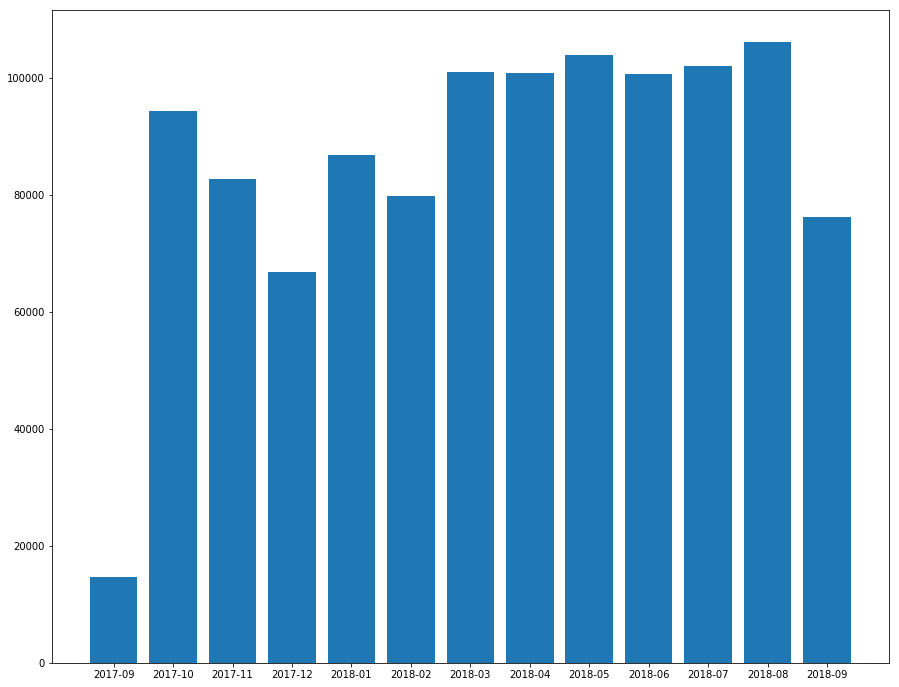

In [19]:
month_year = []
num_transaction = []
for key in monthly_data:
    month_year.append(key)
    num_transaction.append(len(monthly_data[key]))

plt.bar(month_year, num_transaction)
plt.show()

## Check How Days of a Week can Affect Sales
As expected, weekend sales are the weakest followed by Fridays. This analysis suggests that there could be weekly recurrences in the data (i.e. recurring decrease in sales during a weekend). To further the insight, data could also be broken down into individual kiosks or products. We may be able to identify outliers that perform better during weekends.

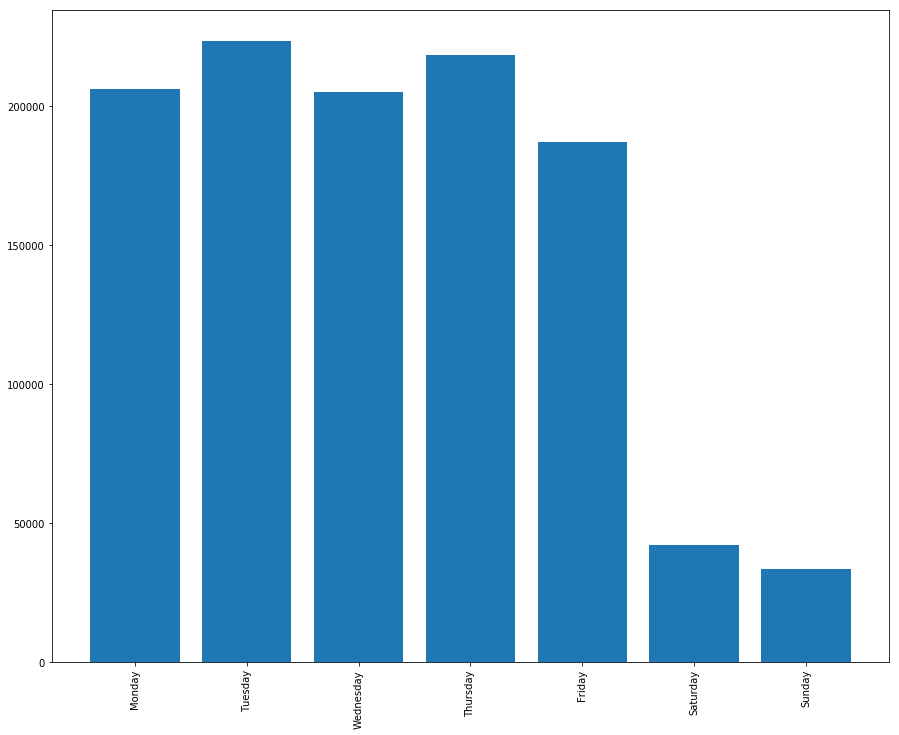

In [108]:
sales = []
for weekday in range(7):
    sales.append(len(df[df.naive_date_time.dt.weekday==weekday]))
plt.bar(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], sales)
plt.xticks(rotation=90)
plt.show()

## Aggregating Data

We know that there are currently 546 different kiosks, 330 different products, and 119780 customers. As there are quite many instances for each of them, analyzing every single one of them is out of the scope of this exercise. So I'm going to gather a subset of 5 kiosks that are performing the worse each month and a subset of 15 products that are selling the most each month. And then I congregate all these subsets over the 12 months to build an interesting portfolio of kiosks and products.

In [21]:
bottom5_kiosk = []
top15_product = []

idx = 0
for key in monthly_data:
    ranked_kiosk = monthly_data[key].groupby("kiosk_id")["kiosk_id"].agg(np.size).sort_values(ascending=False)
    ranked_product = monthly_data[key].groupby("product_id")["product_id"].agg(np.size).sort_values(ascending=False)
    bottom5_kiosk.append(ranked_kiosk[-5:]/num_transaction[idx])
    top15_product.append(ranked_product[:15]/num_transaction[idx])
    idx += 1

#### Plotting the Weakest Performing Kiosks over the 12 Months
From the aggregated time series data, we can can see that the trends can be quite noisy for some of the kiosks. There are kiosks that started selling for a short while and then went offline abruptly (e.g. kiosk 953), ones that have sales declining slowly (e.g. kiosk 254), and ones that took a hiatus for a month or two (e.g. kios 573). Some of kiosks demonstrates correlations between themselves (e.g. kiosk 444 and 703) while others are completely different. 

number of bottom kiosks: 40


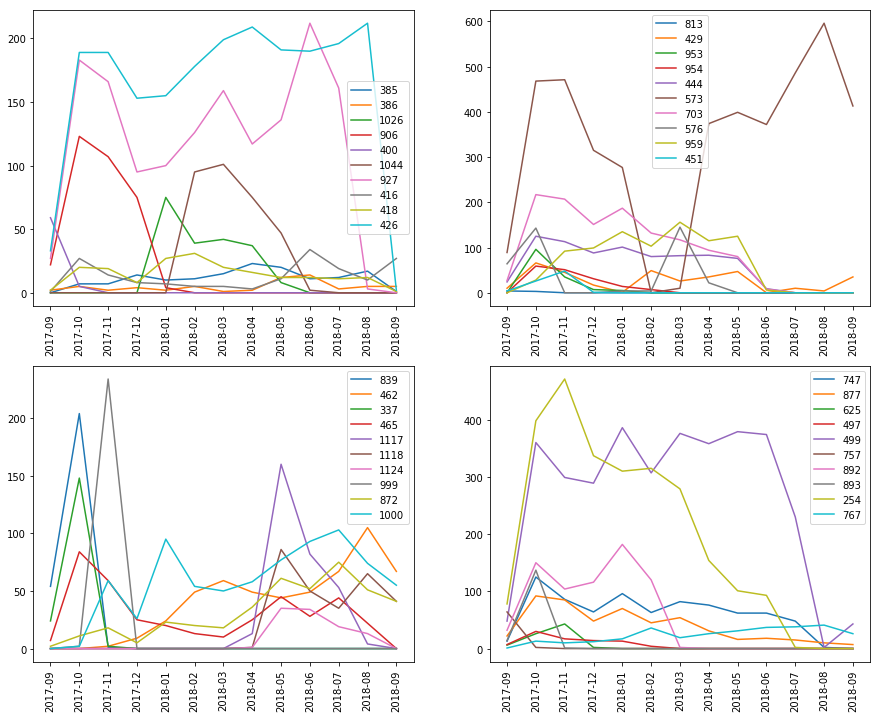

In [22]:
bottom_kiosk_growth = set()
for kiosk in bottom5_kiosk:
    bottom_kiosk_growth = bottom_kiosk_growth.union(set(kiosk.index))
print("number of bottom kiosks:", len(bottom_kiosk_growth))

i = j = 0
for kiosk in bottom_kiosk_growth:
    kiosk_transaction = []
    for t in month_year:
        kiosk_transaction.append(len(monthly_data[t][monthly_data[t].kiosk_id == kiosk]))
    if i%10 == 0:
        lines = []
        plt.subplot(int("22" + str(j+1)))
        j += 1
    lines.append(plt.plot(month_year, kiosk_transaction, label=kiosk)[0])
    plt.legend(handles=lines)
    plt.xticks(rotation=90)
    i += 1

plt.show()

#### Plotting the Popular Products over the 12 Months
The product aggregated data behaves better than the kiosks' as we can see the lines are more smooth as oppposed to jumping and down. That's probably because we are looking at the "most popular" products instead, which returns many more examples. We can see that the kiosk aggregates are in range of hundreds while the product aggregates are in range of thousands. 

Based on the plots, I can see some products were recently introduced (e.g. product 6055) while some products went off the rack despite the popularity (e.g. product 4542). And from these smoother lines, I observe a lot more correlations between these top products (e.g. product 4202, 4203, 4207).

number of top products: 34


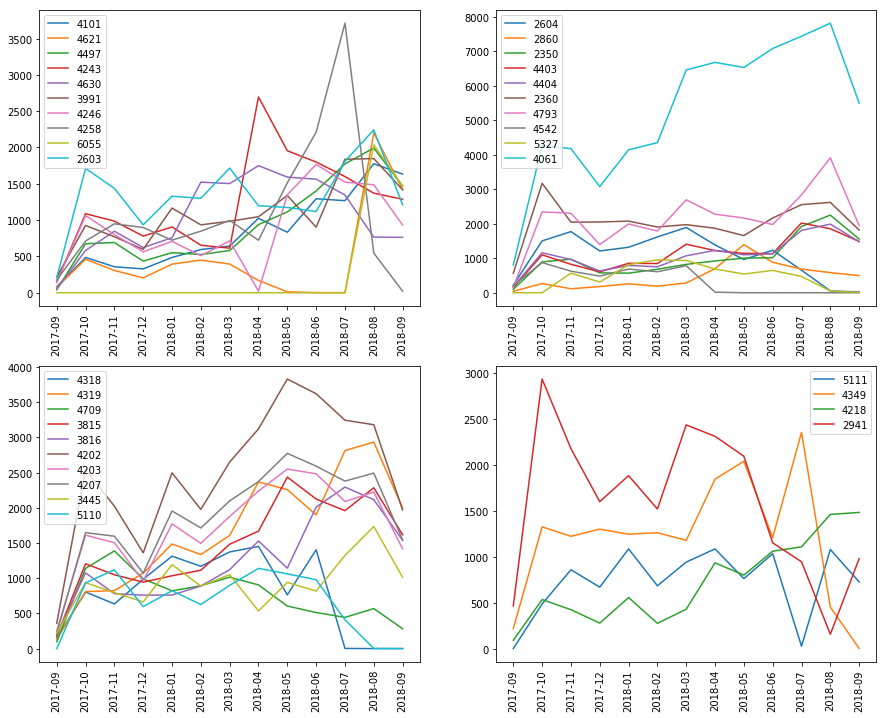

In [23]:
top_product_growth = set()
for product in top15_product:
    top_product_growth = top_product_growth.union(set(product.index))
print("number of top products:", len(top_product_growth))

i = j = 0
for product in top_product_growth:
    product_transaction = []
    for t in month_year:
        product_transaction.append(len(monthly_data[t][monthly_data[t].product_id == product]))
    if i%10 == 0:
        lines = []
        plt.subplot(int("22" + str(j+1)))
        j += 1
    lines.append(plt.plot(month_year, product_transaction, label=product)[0])
    plt.legend(handles=lines)
    plt.xticks(rotation=90)
    i += 1

plt.show()

## Pipeline Preparation

#### Further Break Down the Data to Daily Transactions Per Product and Per Kiosk

In [112]:
unique_kiosk_id = df.kiosk_id.unique()
daily_kiosk_df = pd.DataFrame(index=unique_kiosk_id)
unique_product_id = df.product_id.unique()
daily_product_df = pd.DataFrame(index=unique_product_id)

current = start_date
while current <= end_date + relativedelta(days=+1):
    current_kiosk_df = df[(df.naive_date_time >= current) & (df.naive_date_time < current + relativedelta(days=+1))].groupby("kiosk_id")["kiosk_id"].agg(np.size)
    current_kiosk_df.name = current
    daily_kiosk_df = daily_kiosk_df.join(current_kiosk_df)
    current_product_df = df[(df.naive_date_time >= current) & (df.naive_date_time < current + relativedelta(days=+1))].groupby("product_id")["product_id"].agg(np.size)
    current_product_df.name = current
    daily_product_df = daily_product_df.join(current_product_df)
    current += relativedelta(days=+1)


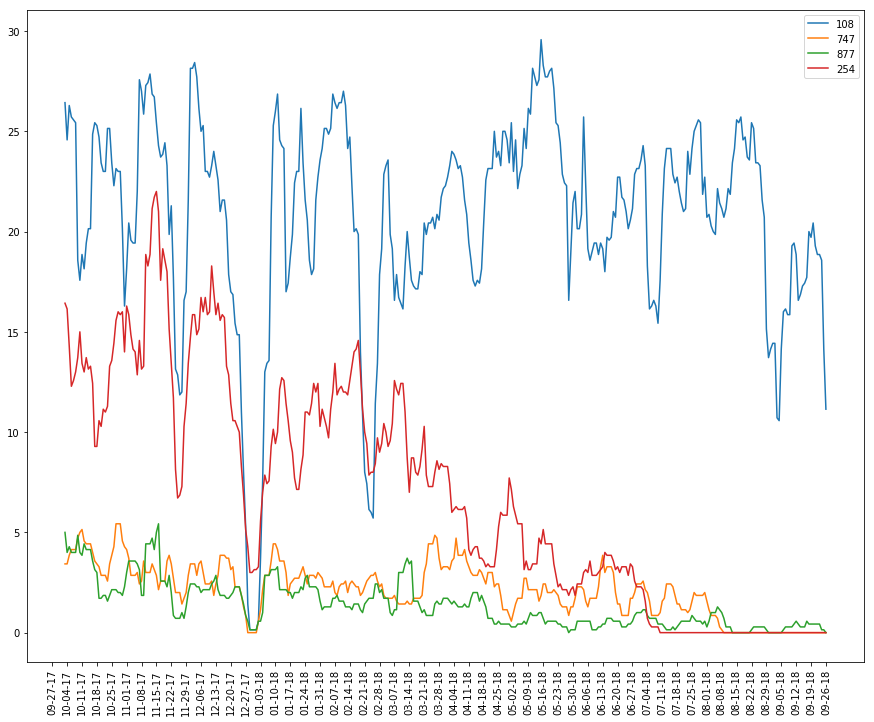

In [113]:
weak_kiosks = [108, 747, 877, 254]
plot_kiosk = daily_kiosk_df.loc[weak_kiosks].T.fillna(0)

fig, ax = plt.subplots()
lines = plt.plot(plot_kiosk.rolling(7).mean())
for i in range(len(weak_kiosks)):
    lines[i].set_label(weak_kiosks[i])

myFmt = mdates.DateFormatter('%m-%d-%y')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks([plot_kiosk.index[i] for i in range(0, len(plot_kiosk.index), 7)], rotation=90)
plt.legend(handles=lines)
plt.show()


#### Further Break Down the Data to Daily Transactions Per Product and Per Kiosk
I hand picked a few of the kiosks from the subset and apply seasonal decomposition. The algorithm neatly decomposes the original data into three components: trend, seasonal, and residual. The seasonal plot clearly demonstrates a weekly recurence for each of these kiosks. The number of cycles on the plot is exactly 52 (i.e. 52 weeks in a year). The residual plot captures any anomaly from the data, leaving a much cleaner representation for the trend. As an example, you can see the kiosk 254 is struggling with sales based on the trend plot while the original observed plot is more obscured due to all the recurrences and noise.

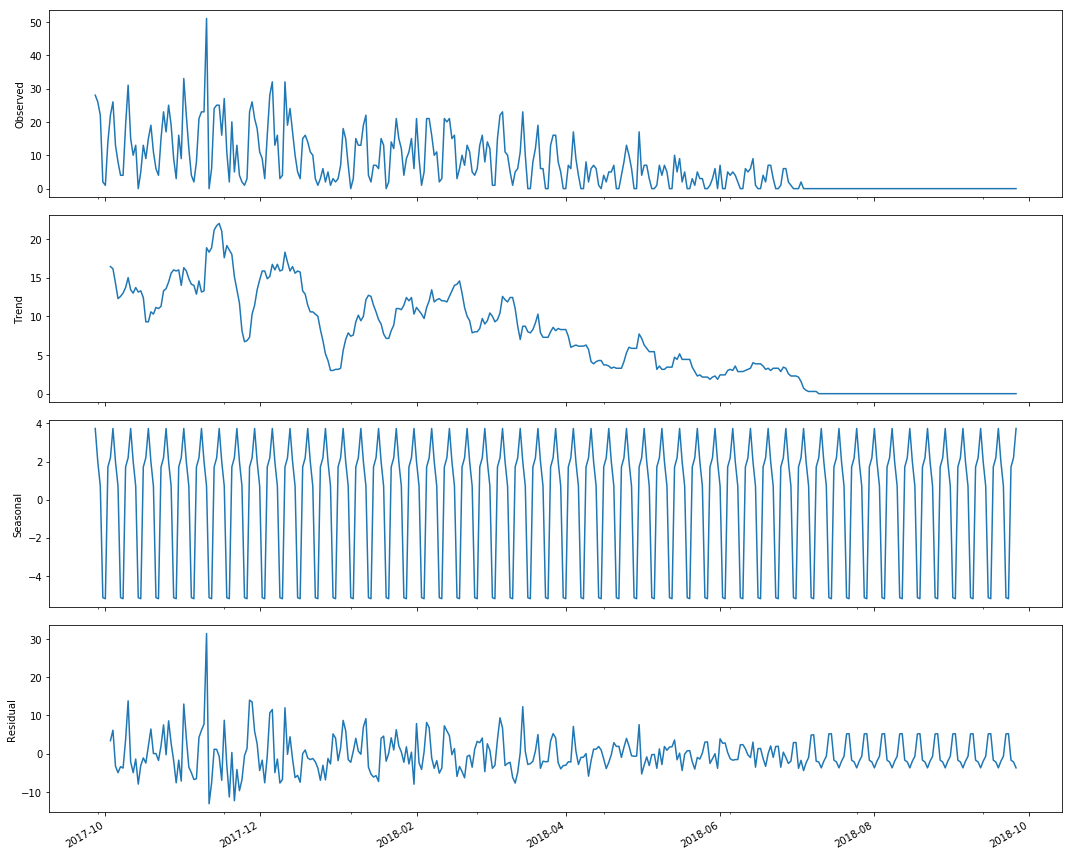

In [125]:
id = 254
kiosk_df = kiosk_weekly_df.T.fillna(0)
kiosk_sd = seasonal_decompose(kiosk_df[id], model='additive', two_sided=False)
kiosk_sd.plot()
plt.show()

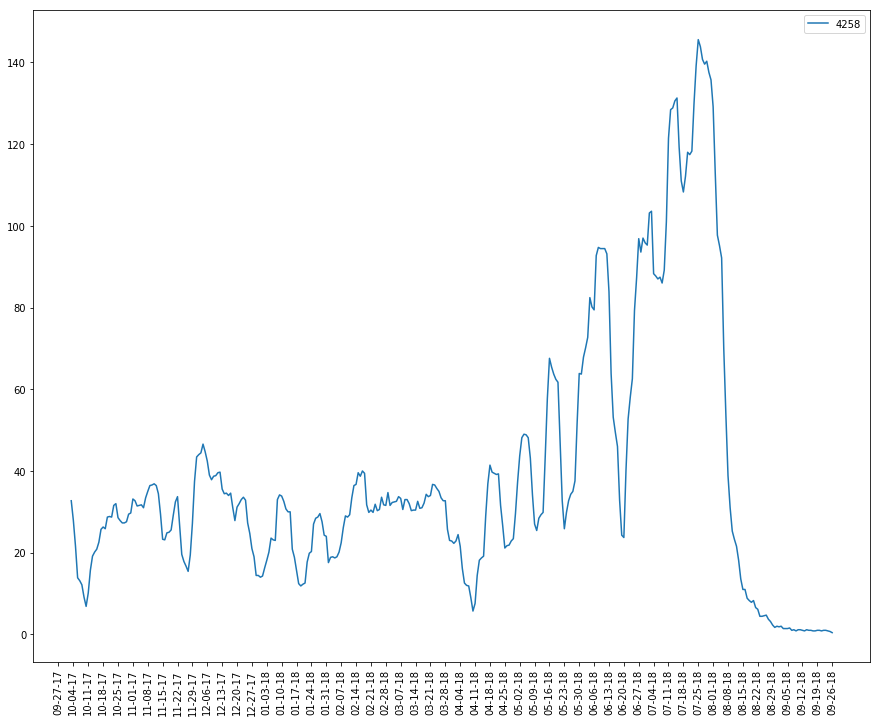

In [123]:
popular_products = [4258]
plot_product = daily_product_df.loc[popular_products].T.fillna(0)

fig, ax = plt.subplots()
lines = plt.plot(plot_product.rolling(7).mean())
for i in range(len(popular_products)):
    lines[i].set_label(popular_products[i])

myFmt = mdates.DateFormatter('%m-%d-%y')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks([plot_product.index[i] for i in range(0, len(plot_product.index), 7)], rotation=90)
plt.legend(handles=lines)
plt.show()

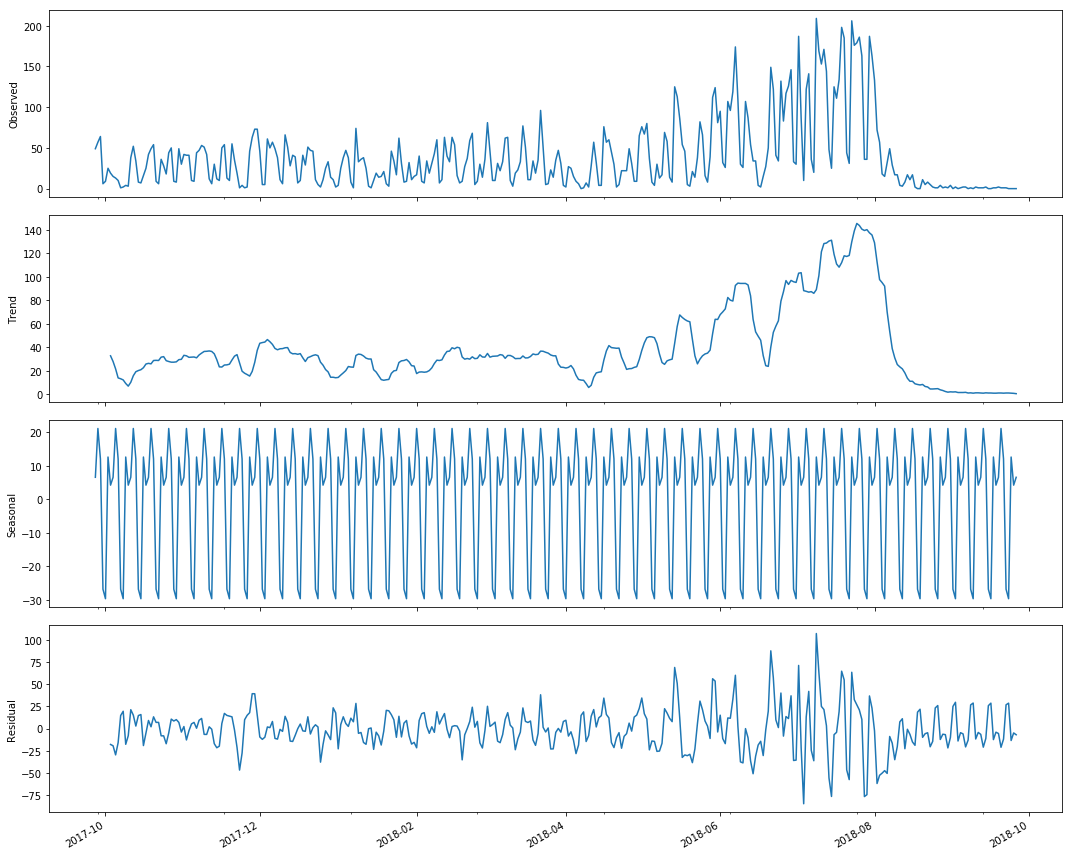

In [126]:
product_id = 4258
product_df = daily_product_df.T.fillna(0)
product_sd = seasonal_decompose(product_df[product_id], model='additive', two_sided=False)
product_sd.plot()
plt.show()